In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


sys.path.append('../src/')
from experiments.evaluate_from_config import agent_from_config
import experiments.parameters as parameters
from core.runner import run_episode
from core.node import Node


In [2]:



challenge = parameters.env_challenges[1]
config_modifications = {
    "agent_type": "distance",
    "max_episode_length": 100,
    "tree_evaluation_policy": "visit",
    "selection_policy": "UCT",
    "planning_budget": 128,
    "puct_c": 1.0,
    }

run_config = {**parameters.base_parameters, **challenge, **config_modifications}
agent, env, tree_evaluation_policy, observation_embedding, planning_budget = (
    agent_from_config(run_config)
)

nrows: 6, ncols: 12


In [3]:
from matplotlib import colors
ncols, nrows = observation_embedding.ncols, observation_embedding.nrows
cliff_coords = [(nrows - 1, col) for col in range(1, ncols - 1)]
goal_coord = (nrows - 1, ncols - 1)
def obs_to_cords(state, ncols):
    row, col = divmod(state, ncols)
    return row, col

def calculate_density(tree: Node, ncols, nrows):
    visitation_counts = tree.state_visitation_counts()
    density = np.zeros((nrows, ncols))
    for state, count in visitation_counts.items():
        if state == None:
            row, col = goal_coord
        else:
            row, col = obs_to_cords(state, ncols)
        density[row, col] = count
    return density


In [4]:
cmap = sns.choose_diverging_palette(as_cmap=False)


interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

In [5]:
def plot_density(density, root_state, cliff_coords, ncols, nrows, cmap=cmap, ax=None):
    for (row, col) in cliff_coords:
        density[row, col] = np.nan  # Remove numbers from the cliff cells

    # Mask the 0.0 entries by setting them to NaN
    density[density == 0.0] = np.nan

    if ax is None:
        fig, ax = plt.subplots()

    # Plot the heatmap on the specified axes
    sns.heatmap(density, cmap=cmap, cbar=False, annot=True, fmt='.1f', mask=np.isnan(density), center=0, ax=ax)

    # mark the root state by a black border
    root_row, root_col = obs_to_cords(root_state, ncols)
    ax.add_patch(plt.Rectangle((root_col, root_row), 1, 1, fill=False, color='black', lw=2, angle=0))
    ax.add_patch(plt.Rectangle(goal_coord, 1, 1, fill=False, color='yellow', lw=2, angle=0))

    for (row, col) in cliff_coords:
        ax.add_patch(plt.Rectangle((col, row), 1, 1, fill=True, color='black', lw=0))

    ax.set_xticks(range(ncols))
    ax.set_yticks(range(nrows))
    ax.set_aspect('equal')  # Set aspect ratio to be equal, making each cell square

    return ax


def plot_tree(tree: Node, cliff_coords=cliff_coords, ncols=ncols, nrows=nrows, cmap=cmap):
    density = calculate_density(tree, ncols, nrows)
    return plot_density(density, tree.observation, cliff_coords, ncols, nrows, cmap)


nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12


<Axes: >

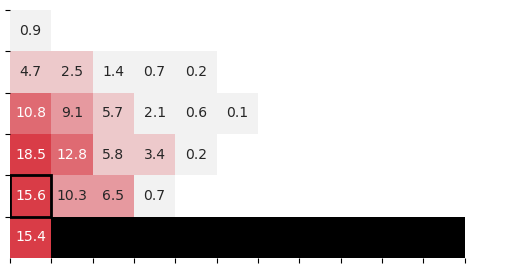

In [6]:
def build_tree(run_config, action_sequence = [], seed = None):
    agent, env, tree_evaluation_policy, observation_embedding, planning_budget = agent_from_config(run_config)

    if seed is not None:
        np.random.seed(seed)
    observation, info = env.reset(seed=seed)
    for action in action_sequence:
        observation, reward, done, _, _ = env.step(action)
        if done:
            break


    tree = agent.search(env, planning_budget, observation, 0.0)
    return tree

seeds = range(10)
action_sequence = [0]
trees = [build_tree(run_config, action_sequence=action_sequence, seed = seed) for seed in seeds]
densites = np.array([calculate_density(tree, ncols, nrows) for tree in trees])
mean_density = np.mean(densites, axis=0)
plot_density(mean_density, trees[0].observation, cliff_coords, ncols, nrows)


nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12


<Axes: >

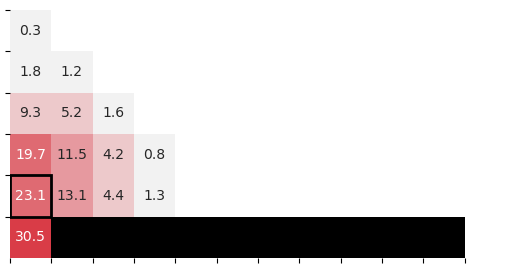

In [7]:
pol_uct = {"puct_c": 100.0}
conf2 = {**run_config, **pol_uct}
trees = [build_tree(conf2, action_sequence=action_sequence, seed = seed) for seed in seeds]
densites = np.array([calculate_density(tree, ncols, nrows) for tree in trees])
mean_density2 = np.mean(densites, axis=0)
plot_density(mean_density2, trees[0].observation, cliff_coords, ncols, nrows)

<Axes: >

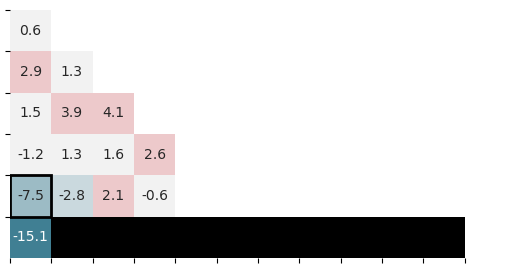

In [8]:
diff = mean_density - mean_density2
diff
plot_density(diff, trees[0].observation, cliff_coords, ncols, nrows)

In [26]:


def get_diff(config0, config1, action_sequence, seeds):
    trees0 = [build_tree(config0, action_sequence=action_sequence, seed = seed) for seed in seeds]
    densites0 = np.array([calculate_density(tree, ncols, nrows) for tree in trees0])
    mean_density0 = np.mean(densites0, axis=0)

    trees1 = [build_tree(config1, action_sequence=action_sequence, seed = seed) for seed in seeds]
    densites1 = np.array([calculate_density(tree, ncols, nrows) for tree in trees1])
    mean_density1 = np.mean(densites1, axis=0)

    diff = mean_density0 - mean_density1
    observation = trees0[0].observation
    return diff, observation

seeds = range(100)
action_sequences = [[0, 0, 1,1,1,1,1,1], [0, 0, 1,1,1,1,1,1, 0,0], [0, 0, 1,1,1,1,1,1,1,1,1,1, 0, 1]]

diffs = [get_diff(conf2, run_config, action_sequence, seeds) for action_sequence in action_sequences]
diffs

nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12
nrows: 6, ncols: 12


[(array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.33, -0.42, -0.4 , -1.02,
          -0.35, -0.01,  0.  ],
         [ 0.  ,  0.  ,  0.  ,  0.  ,  0.6 ,  0.65, -0.21, -2.78, -1.74,
          -1.54, -0.38, -0.02],
         [ 0.  ,  0.  ,  0.  ,  0.64,  1.82,  1.23, -0.53, -1.93, -3.89,
          -1.41, -0.66, -0.1 ],
         [ 0.  ,  0.  ,  0.21,  0.96,  1.73,  2.59,  0.69, -0.53, -0.96,
          -1.37, -0.13, -0.09],
         [ 0.21,  0.  ,  0.  ,  0.41,  1.65,  1.93,  2.14,  1.01, -0.2 ,
           0.46, -0.08,  0.  ],
         [ 1.49,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
           0.  ,  0.  ,  0.  ]]),
  42),
 (array([[ 0.  ,  0.  ,  0.  ,  0.01,  2.61,  4.28,  6.33,  2.76,  0.64,
          -1.04, -0.85, -0.08],
         [ 0.  ,  0.  ,  0.  ,  0.85,  1.97,  5.73,  3.16,  2.88, -2.59,
          -3.12, -1.46, -0.54],
         [ 0.  ,  0.  ,  0.  ,  0.42,  1.88,  2.93,  2.89, -2.46, -4.75,
          -3.36, -1.85, -0.56],
         [ 0.  ,  0.  ,  0.  ,  0.  ,  0.59,  

In [36]:
# change the order of 0 and 1 in diffs
# diffs[0], diffs[1] = diffs[1], diffs[0]

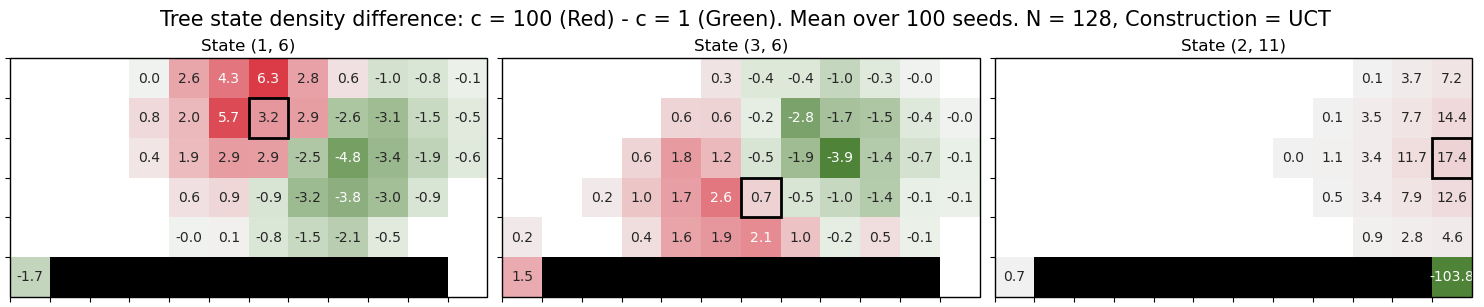

In [37]:
# from matplotlib.colors import LinearSegmentedColormap

# # Create a custom diverging color palette from blue to white to red
# colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # B -> W -> R
# n_bins = 100  # Number of bins in the colormap
# cmap_name = 'blue_white_red'
# cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
cmap = sns.diverging_palette(120, 10, as_cmap=True, center="light")

# plot for each action sequence
fig, axs = plt.subplots(1, len(action_sequences), figsize=(15, 3))

for i, (diff, observation) in enumerate(diffs):
    # scaled_diff = (diff * 100 / planning_budget)
    plot_density(diff, observation, cliff_coords, ncols, nrows, cmap, ax=axs[i])
    axs[i].set_title(f'State {obs_to_cords(observation, ncols)}')

# Adjust layout
plt.tight_layout()
fig.suptitle(f"Tree state density difference: c = 100 (Red) - c = 1 (Green). Mean over {len(seeds)} seeds. N = {run_config['planning_budget']}, Construction = UCT", fontsize=15, y=1.06)

# Add a border around each subplot after tight_layout adjustment
for ax in axs:
    pos = ax.get_position()
    fig.add_artist(plt.Rectangle((pos.x0, pos.y0), pos.width, pos.height, edgecolor='black', fill=False, lw=1))

plt.savefig(f"outfiles/density_diff_{run_config['planning_budget']}_c.pdf", bbox_inches='tight')
plt.show()
